# 0. BIBLIOTECAS, FUNÇÕES E CARGA DE DADOS

## 0.1. BIBLIOTECAS

In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import psycopg2 as pg
# from scipy import stats
from scipy.stats import chisquare, chi2_contingency, mannwhitneyu

import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

# from boruta import BorutaPy

## 0.2. FUNÇÕES

In [3]:
# função para devolver alguns detalhes de cada coluna
def column_analysis(data, column, dataframe = True):
    if dataframe == False:
        print('-' * 25)
        print(f'Nome:          {column}')
        print(f'Cardinalidade: {data[column].nunique()}')
        print(f'Dados únicos:  {data[column].unique()}')
        print(f'Tipo:          {data[column].dtypes}')
    else:
        return (column, data[column].nunique(), str(data[column].unique()), data[column].isna().sum(), data[column].dtypes)

# função para calcular a correlação de cramer
def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape

    chi2 = chi2_contingency(cm)[0]
    
    chi2_corr = max(0, chi2 - ((k - 1) * (r - 1) / (n - 1)))
    k_corr = k - (k - 1) ** 2 / (n - 1)
    r_corr = r - (r - 1) ** 2 / (n - 1)

    return np.sqrt((chi2_corr / n) / (min(k_corr - 1, r_corr - 1)))


def show_values(axs, orient = "v", space = 0.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height() * 0.01)
                value = '{:.1f}'.format(p.get_height())
                ax.text(_x, _y, value, ha = "center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.1f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

def plot_bar(data, column):
    if column == 'genero':
        x_values = data[column].replace({0: 'Masculino', 1: 'Feminino'}).value_counts().sort_index().index
    else:
        x_values = data[column].replace({0: 'Não', 1: 'Sim'}).value_counts().sort_index().index
    y_values = data[column].value_counts(normalize = True).sort_index().values * 100
    p = sns.barplot(x = x_values, y = y_values, label = f'{column}')
    show_values(p)
    plt.title(f'Análise univariada - {column}', loc = 'left', fontsize = 14)
    plt.ylim(0, 100)
    plt.ylabel('Porcentagem (%)')

def plot_pie(data, column):
    plt.pie(data[column].value_counts(normalize = True).values, labels = data[column].replace(0, 'Nenhuma').value_counts().index, autopct = '%.2f' + '%%')
    plt.title(f'Análise univariada - {column}', loc = 'left', fontsize = 14)

def plot_hist(data, column):
    plt.hist(data[column], bins = 20)
    plt.title(f'Análise univariada - {column}', loc = 'left', fontsize = 14)
    plt.xlabel(f'{column}')
    plt.ylabel('Volumetria')

def precision_top_k(data, k = 2000):
    data = data.reset_index(drop = True)

    data['ranking'] = data.index + 1

    data['precision_top_k'] = data.response.cumsum() / data.ranking

    return data.loc[k, 'precision_top_k']

def recall_top_k(data, k = 2000):
    data = data.reset_index(drop = True)

    data['ranking'] = data.index + 1

    data['recall_top_k'] = data.response.cumsum() / data.response.sum()

    return data.loc[k, 'recall_top_k']

## 0.3. CARGA DE DADOS

In [4]:
# carregando os dados
data = pd.read_csv('./data/raw/train.csv')

# verificando
data.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


# 1. DESCRIÇÃO DOS DADOS

In [5]:
# backup
data_01 = data.copy()

## 1.1. DESCRIÇÃO GERAL

In [6]:
# breve descrição dos dados
columns_descriptions = []

for column in data_01.columns:
    column_description = column_analysis(data_01, column)
    columns_descriptions.append(column_description)

pd.DataFrame(columns_descriptions, columns = ['nome', 'cardinalidade', 'dados_unicos', 'dados_nulos', 'tipo'])

,nome,cardinalidade,dados_unicos,dados_nulos,tipo
0,id,381109,[ 1 2 3 ... 381107 381108 381109],0,int64
1,Gender,2,['Male' 'Female'],0,object
2,Age,66,[44 76 47 21 29 24 23 56 32 41 71 37 25 42 60 ...,0,int64
3,Driving_License,2,[1 0],0,int64
4,Region_Code,53,[28. 3. 11. 41. 33. 6. 35. 50. 15. 45. 8. 3...,0,float64
5,Previously_Insured,2,[0 1],0,int64
6,Vehicle_Age,3,['> 2 Years' '1-2 Year' '< 1 Year'],0,object
7,Vehicle_Damage,2,['Yes' 'No'],0,object
8,Annual_Premium,48838,[ 40454. 33536. 38294. ... 20706. 101664. ...,0,float64
9,Policy_Sales_Channel,155,[ 26. 152. 160. 124. 14. 13. 30. 156. 163. ...,0,float64


- O dataframe não possui nenhuma linha com dado nulo aparentemente;
- Os nomes das colunas serão colocados todos com letras minúsculas para facilitar a manipulação;
- Os valores das seguintes colunas estão como float, irei alterar para inteiro:
    - region_code;
    - annual_premium;
    - policy_sales_channel.

### 1.1.1. ALTERAÇÕES

In [7]:
# nome das colunas contém algumas letras maiúsculas, passar tudo para minúsculo
data_01.columns = list(map(lambda x: x.lower(), data_01.columns))

# verificando
data_01.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [8]:
# os valores das seguintes colunas estão como float, mudar os valores dessas colunas para inteiro
data_01['region_code'] = data_01['region_code'].astype(int)
data_01['annual_premium'] = data_01['annual_premium'].astype(int)
data_01['policy_sales_channel'] = data_01['policy_sales_channel'].astype(int)

# verificando
data_01.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1,Male,44,1,28,0,> 2 Years,Yes,40454,26,217,1
1,2,Male,76,1,3,0,1-2 Year,No,33536,26,183,0
2,3,Male,47,1,28,0,> 2 Years,Yes,38294,26,27,1
3,4,Male,21,1,11,1,< 1 Year,No,28619,152,203,0
4,5,Female,29,1,41,1,< 1 Year,No,27496,152,39,0


## 1.2. ESTATÍSTICA DESCRITIVA

In [9]:
# organizando as variáveis por tipo
target_column = ['response']

categorical_columns = ['gender', 'vehicle_age', 'vehicle_damage', 'driving_license', 'region_code', 'previously_insured', 'policy_sales_channel']
dichotomic_columns = ['gender', 'vehicle_damage', 'driving_license', 'previously_insured']
polichotomic_columns = ['vehicle_age', 'region_code', 'policy_sales_channel']

numerical_columns = ['age', 'annual_premium','vintage']

In [10]:
# separando os dados em numéricos e categóricos para analisar
categorical_data = data_01[categorical_columns]
numerical_data = data_01[numerical_columns]

### 1.2.1. ATRIBUTOS NUMÉRICOS

In [11]:
# métricas de medida central: media e mediana
ct1 = pd.DataFrame(numerical_data.apply(np.mean)).T
ct2 = pd.DataFrame(numerical_data.apply(np.median)).T

# métricas de dispersão: desvio padrão, min, max, range, skew, kurtosis
d1 = pd.DataFrame (numerical_data.apply (np.std)).T
d2 = pd.DataFrame (numerical_data.apply (min)).T
d3 = pd.DataFrame (numerical_data.apply (max)).T
d4 = pd.DataFrame (numerical_data.apply (lambda x: x.max() - x.min())).T
d5 = pd.DataFrame (numerical_data.apply (lambda x: x.skew())).T
d6 = pd.DataFrame (numerical_data.apply (lambda x: x.kurtosis())).T

# concat
m = pd.concat([ d2, d3, d4, ct1, ct2, d1, d5, d6 ]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,age,20.0,85.0,65.0,38.822584,36.0,15.511591,0.672539,-0.565655
1,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087,34.004569
2,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,0.003030,-1.200688


Destaques:
- age: Mediana = 36 anos, std = 15,5 anos -> 68% das pessoas dessa base possuem idades entre 20,5 anos e 51,5 anos.
- annual_premium: Possui um alto valor de range, alta kurtosis e valores muito extremos (outliers).
- vintage: Muito uniforme, provavelmente não irá ajudar muito na modelagem.

### 1.2.2. ATRIBUTOS CATEGORICOS

In [12]:
# variações de cada coluna
print(f"- Valores distintos:\n{categorical_data.apply(lambda x: x.unique().shape[0])}\n")
print(f"- Variações:\n{categorical_data.apply(lambda x: x.unique())}")

- Valores distintos:
gender                    2
vehicle_age               3
vehicle_damage            2
driving_license           2
region_code              53
previously_insured        2
policy_sales_channel    155
dtype: int64

- Variações:
gender                                                     [Male, Female]
vehicle_age                               [> 2 Years, 1-2 Year, < 1 Year]
vehicle_damage                                                  [Yes, No]
driving_license                                                    [1, 0]
region_code             [28, 3, 11, 41, 33, 6, 35, 50, 15, 45, 8, 36, ...
previously_insured                                                 [0, 1]
policy_sales_channel    [26, 152, 160, 124, 14, 13, 30, 156, 163, 157,...
dtype: object


## 1.3. TESTES ESTÁTISTICOS

### 1.3.1. VARIÁVEIS NUMÉRICAS

Hipóteses:
- H0: Não há diferença entre os grupos
- H1: Há diferença entre os grupos

Significância:
* Se o p_value for maior que 5%, não rejeitar a hipótese nula
* Se o p_value for menor que 5%, rejeitar a hipótese nula

In [13]:
# 
columns = numerical_columns
significance = 0.05
p_values = []
results = []

for column in columns:
    statistic, p_value = mannwhitneyu(
        data_01[data_01.response == 1][column], 
        data_01[data_01.response == 0][column]
    )
    
    p_values.append(p_value.round(4))

    if p_value <= significance:
        result = 'Rejeitar H0, há diferença entre os grupos'
    else:
        result = 'Não rejeitar H0, não há diferença entre os grupos'

    results.append(result)


pd.DataFrame({
    'p_value': p_values,
    'result': results
}, index = columns)

,p_value,result
age,0.0000,"Rejeitar H0, há diferença entre os grupos"
annual_premium,0.0000,"Rejeitar H0, há diferença entre os grupos"
vintage,0.5163,"Não rejeitar H0, não há diferença entre os grupos"


### 1.3.2. VARIÁVEIS CATEGORICAS

#### 1.3.2.1. DICOTÓMICAS

In [14]:
# aplicando o teste estatístico de comparação entre a coluna que se quer avaliar e a coluna 'response'
# Chi-square of Goodness of fit test
columns = dichotomic_columns
significance = 0.05
p_values_response_yes = []
p_values_response_no = []
results_response_yes = []
results_response_no = []

for column in columns:
    odds, p_value = chisquare(pd.crosstab(data_01[column], data_01.response))

    p_values_response_yes.append(p_value[1].round(4))
    p_values_response_no.append(p_value[0].round(4))

    if p_value[1] > significance:
        result_yes = 'Não rejeitar H0, não há diferença entre os grupos'
    else:
        result_yes = 'Rejeitar H0, há diferença entre os grupos'

    if p_value[0] > significance:
        result_no = 'Não rejeitar H0, não há diferença entre os grupos'
    else:
        result_no = 'Rejeitar H0, há diferença entre os grupos'

    results_response_yes.append(result_yes)
    results_response_no.append(result_no)

pd.DataFrame({'p_value (response = Yes)': p_values_response_yes,
              'result (response = Yes)': results_response_yes,
              'p_value (response = No)': p_values_response_no,
              'result (response = No)': results_response_no}, 
              index = columns)

,p_value (response = Yes),result (response = Yes),p_value (response = No),result (response = No)
gender,0.0,"Rejeitar H0, há diferença entre os grupos",0.0,"Rejeitar H0, há diferença entre os grupos"
vehicle_damage,0.0,"Rejeitar H0, há diferença entre os grupos",0.0,"Rejeitar H0, há diferença entre os grupos"
driving_license,0.0,"Rejeitar H0, há diferença entre os grupos",0.0,"Rejeitar H0, há diferença entre os grupos"
previously_insured,0.0,"Rejeitar H0, há diferença entre os grupos",0.0,"Rejeitar H0, há diferença entre os grupos"


#### 1.3.2.2. POLICOTÓMICAS

In [15]:
# aplicando o teste estatístico de comparação entre a coluna que se quer avaliar e a coluna 'response' 
# Chi-square test for independence
columns = polichotomic_columns
significance = 0.05
p_values = []
results = []

for column in columns:
    chi2_statistic, p_value, dof = chi2_contingency(pd.crosstab(data_01[column], data_01.response))[0:3]

    p_values.append(p_value.round(4))

    if p_value > significance:
        result = 'Independentes (Não rejeitar H0, não há diferença entre os grupos)'
    else:
        result = 'Dependentes (Rejeitar H0, há diferença entre os grupos)' #there is no effect of group in choosing the equipment to use

    results.append(result)

pd.DataFrame({'p_value': p_values,
              'result': results},
              index = columns)

,p_value,result
vehicle_age,0.0,"Dependentes (Rejeitar H0, há diferença entre o..."
region_code,0.0,"Dependentes (Rejeitar H0, há diferença entre o..."
policy_sales_channel,0.0,"Dependentes (Rejeitar H0, há diferença entre o..."


# 2. FEATURE ENGINNERING

In [16]:
# backup
data_02 = data_01.copy()

## 2.1. GERAR HIPÓTESES

1. Pessoas com idade mais elevada deveriam mostrar mais interesse.
2. Pessoas que possuem carteira de habilitação deveriam mostrar mais interesse.
3. Pessoas que já possuem seguro deveriam mostrar mais interesse.
4. Pessoas que possuem veículos mais novos deveriam mostrar mais interesse.
5. Pessoas que já tiveram seus veículos danificados deveriam mostrar mais interesse.
6. Pessoas que possuem um alto valor de despesas de saúde deveriam mostrar mais interesse.
7. Pessoas que possuem mais dias associados deveriam mostrar mais interesse.

# 3. FILTRAGEM DE VARIÁVEIS

In [17]:
# backup
data_03 = data_02.copy()

- A principio, todas as variáveis serão utilizadas.

# 4. EXPLORAÇÃO DOS DADOS

In [18]:
# backup
data_04 = data_03.copy()

## 4.1. ANÁLISE UNIVARIADA

### 4.1.1. VARIÁVEL RESPOSTA

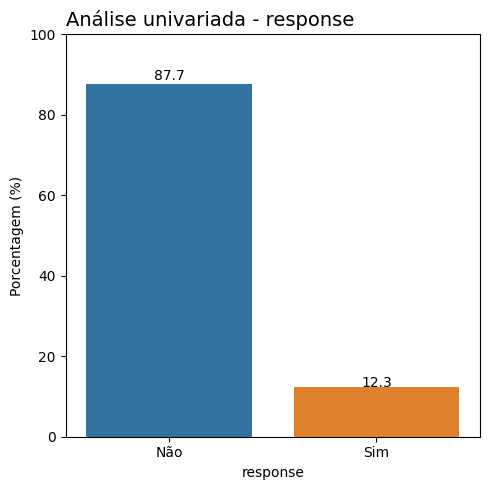

In [19]:
# distribuição da coluna target
plt.figure(figsize = (5, 5))
for position, column in enumerate(target_column):
    plt.subplot(1, 1, position + 1)
    plot_bar(data_04, column)

plt.tight_layout()

- A variável target, response, possui uma taxa de clientes que gostariam de ter um novo seguro de apenas 12,3%, isso mostra o desbalanceamento da nossa base de dados.

### 4.1.2. VARIÁVEIS NUMÉRICAS

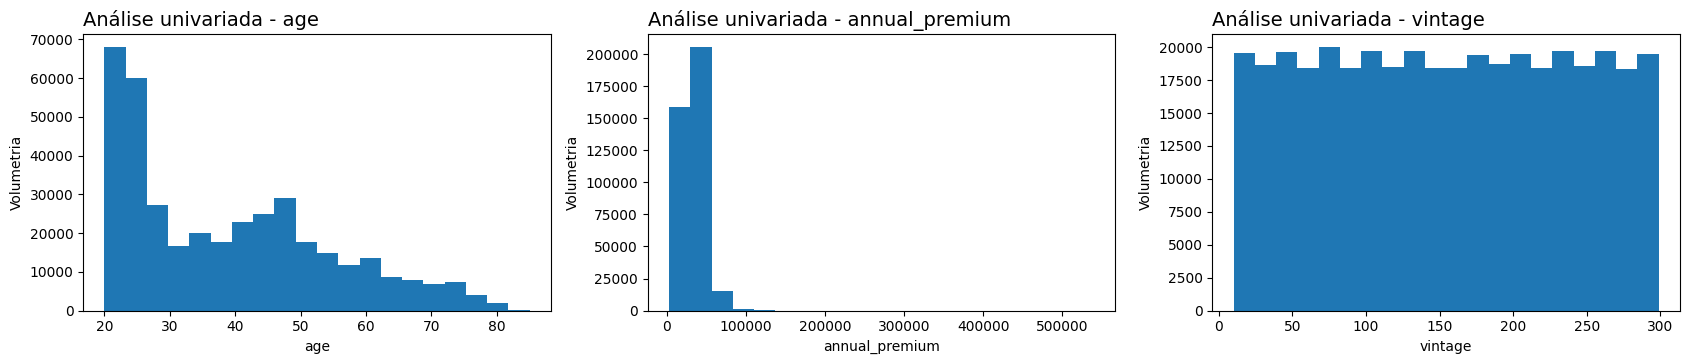

In [20]:
# distriuições das colunas numericas
plt.figure(figsize = (17, 10))
for position, column in enumerate(numerical_columns):
    plt.subplot(3, 3, position + 1)
    plot_hist(data_04, column)

plt.tight_layout()
plt.show()

### 4.1.3. VARIÁVEIS CATEGORICAS

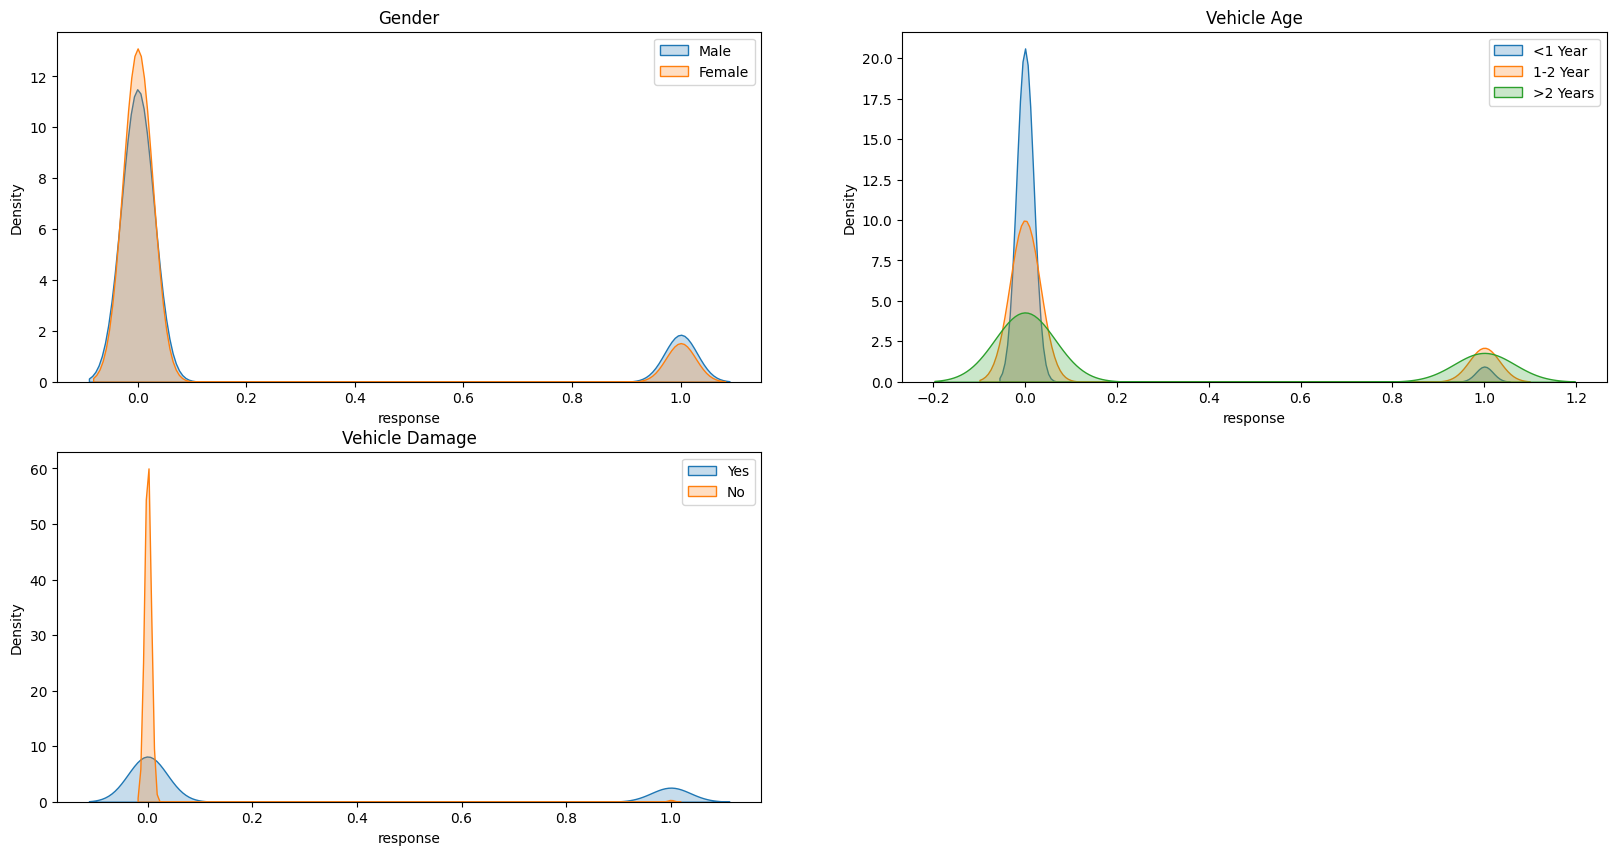

In [21]:
plt.figure(figsize = (20, 10))

plt.subplot(2, 2, 1)
plt.title('Gender')
sns.kdeplot(data_04[data_04.gender == 'Male'].response, label = 'Male', shade = True)
sns.kdeplot(data_04[data_04.gender == 'Female'].response, label = 'Female', shade = True)
plt.legend()

plt.subplot(2, 2, 2)
plt.title('Vehicle Age')
sns.kdeplot(data_04[data_04.vehicle_age == '< 1 Year'].response, label = '<1 Year', shade = True)
sns.kdeplot(data_04[data_04.vehicle_age == '1-2 Year'].response, label = '1-2 Year', shade = True)
sns.kdeplot(data_04[data_04.vehicle_age == '> 2 Years'].response, label = '>2 Years', shade = True)
plt.legend()

plt.subplot(2, 2, 3)
plt.title('Vehicle Damage')
sns.kdeplot(data_04[data_04.vehicle_damage == 'Yes'].response, label = 'Yes', shade = True)
sns.kdeplot(data_04[data_04.vehicle_damage == 'No'].response, label = 'No', shade = True)
plt.legend()

## 4.2. ANÁLISE BIVARIADA

### 4.2.1. GENDER X RESPONSE

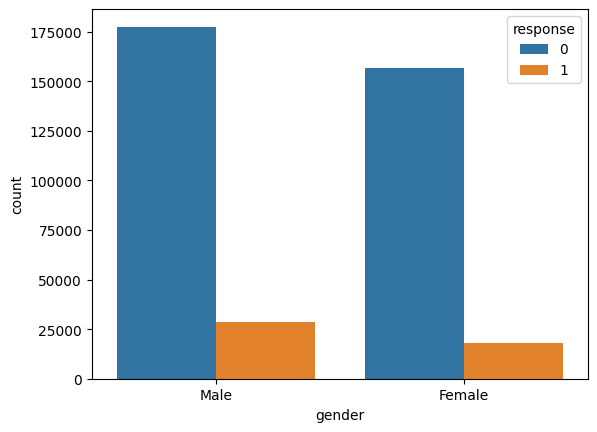

In [22]:
# comparação entre genêro e a variável resposta
sns.countplot(x = 'gender', hue = 'response', data = data_04)

plt.show()

- Visualmente, não existe diferença pelo gênero entre os que possuem interesse e os que não possuem interesse, porém, pela análise estatística, foi verificado que essa é uma variável relevante para estudo.

### 4.2.2. AGE X RESPONSE

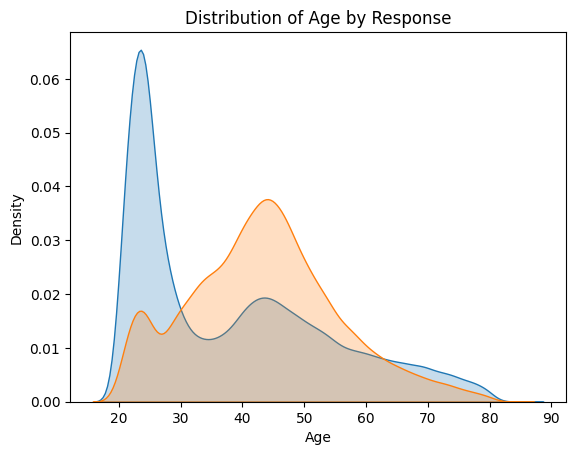

In [23]:
# comparação da distribuição de idade e a variável resposta
sns.kdeplot(data_04[data_04.response == 0].age, shade = True, label = 'response = 0')
sns.kdeplot(data_04[data_04.response == 1].age, shade = True, label = 'response = 1')

plt.xlabel('Age')
plt.ylabel('Density')
plt.title('Distribution of Age by Response')
plt.show()

- Visualmente, existe diferença pela idade entre os que possuem interesse e os que não possuem interesse, corroborando o que foi visto pela análise estatística, sendo uma variável relevante para estudo.

### 4.2.3. DRIVING_LICENSE X RESPONSE

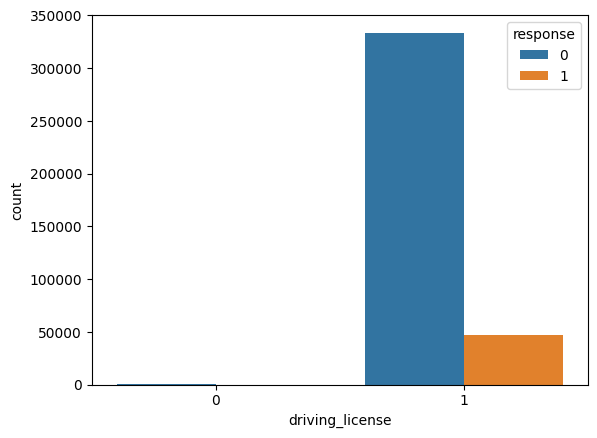

In [24]:
# comparação entre genêro e a variável resposta
sns.countplot(x = 'driving_license', hue = 'response', data = data_04)

plt.show()

- Praticamente toda a base de dados possui carteira de habilitação, mesmo a estatística mostrando que existe uma diferença entre os grupos, essa variável pode não ser interessante para estudo.

### 4.2.4. REGION_CODE X RESPONSE

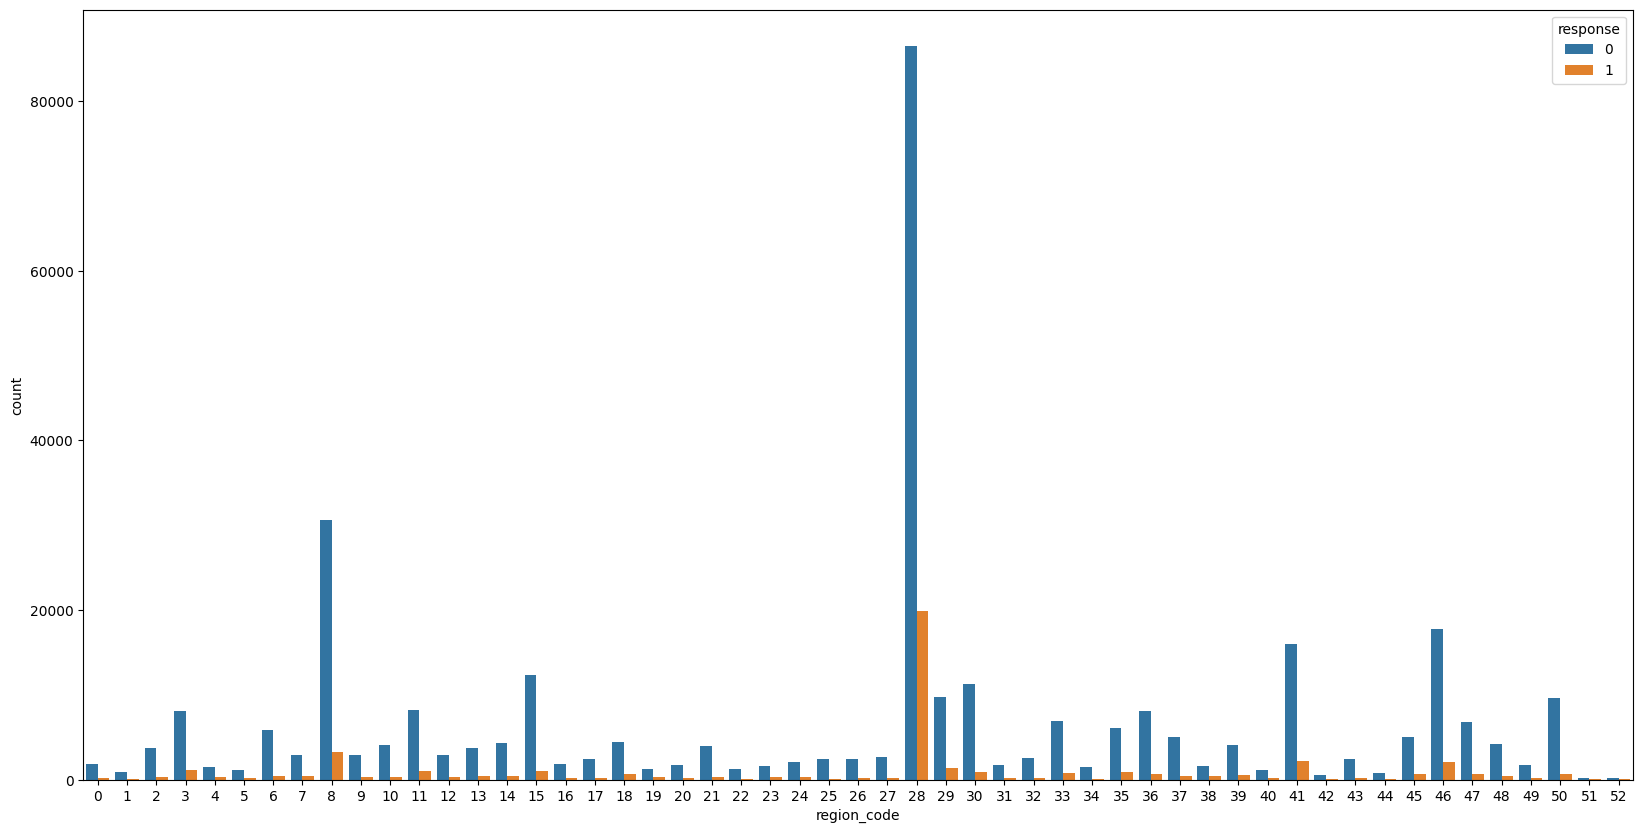

In [25]:
# comparação entre region_code e a variável resposta
plt.figure(figsize = (20, 10))
sns.countplot(x = 'region_code', hue = 'response', data = data_04)

plt.show()

- A distribuição da variável de código de região com relação a variável resposta indica que existe diferença entre os grupos, corroborando assim com o teste estatístico.

### 4.2.5. PREVIOUSLY_INSURED X RESPONSE

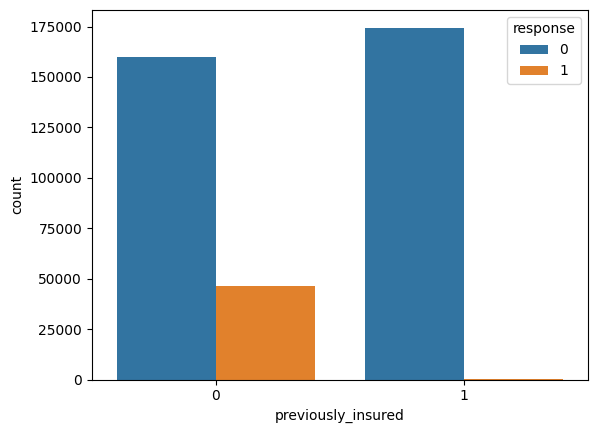

In [26]:
# comparação entre region_code e a variável resposta
sns.countplot(x = 'previously_insured', hue = 'response', data = data_04)

plt.show()

- Pela análise do gráfico e corroborando com as análises estatísticas, essa variável é relevante para estudo.

### 4.2.6. VEHICLE_AGE x RESPONSE

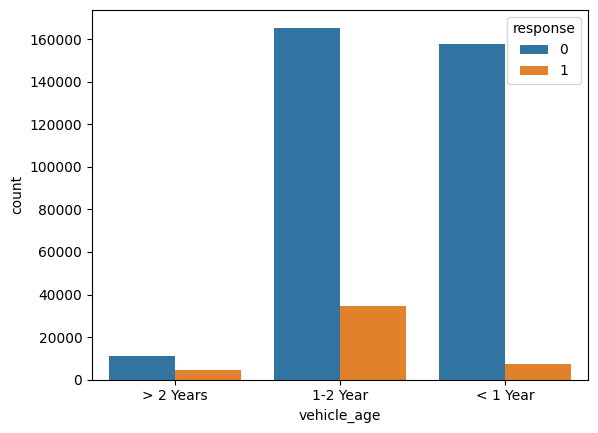

In [27]:
# comparação entre region_code e a variável resposta
sns.countplot(x = 'vehicle_age', hue = 'response', data = data_04)

plt.show()

- Pela análise do gráfico e corroborando com as análises estatísticas, essa variável é relevante para estudo.

### 4.2.7. VEHICLE_DAMAGE X RESPONSE

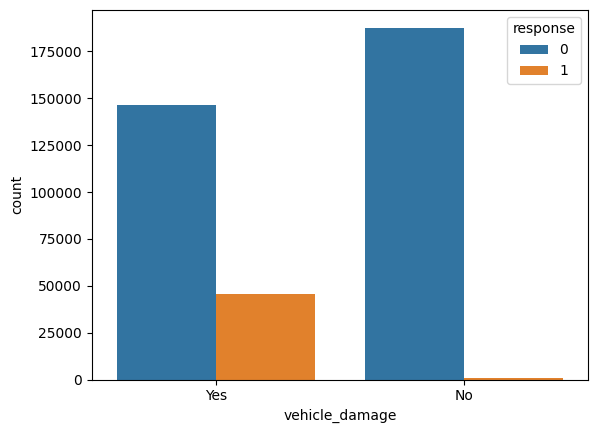

In [28]:
# comparação entre region_code e a variável resposta
sns.countplot(x = 'vehicle_damage', hue = 'response', data = data_04)

plt.show()

- Pela análise do gráfico e corroborando com as análises estatísticas, essa variável é relevante para estudo.

## 4.3. ANÁLISE MULTIVARIADA

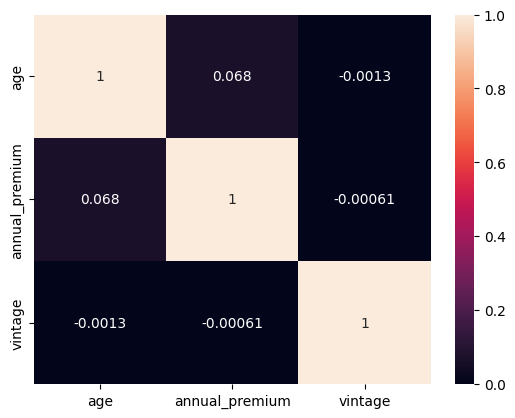

In [29]:
# obtendo a correlação das variáveis numéricas
correlation = numerical_data.corr(method = 'pearson')

# plotando o mapa de calor da correlação
sns.heatmap(correlation, annot = True)
plt.show()

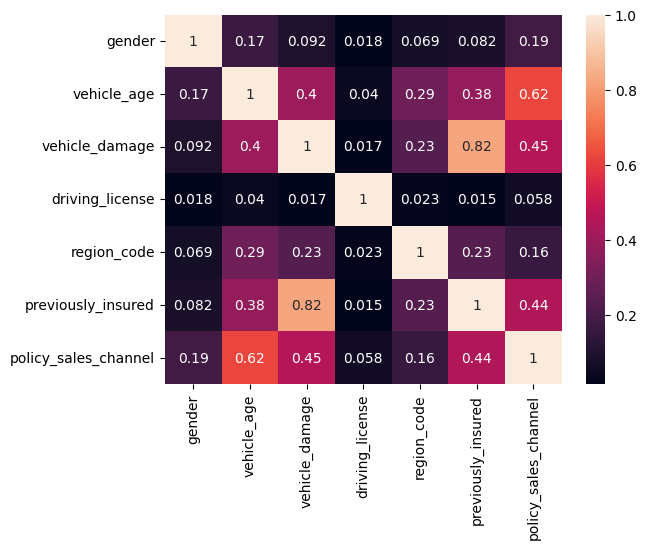

In [40]:
# selecionando apenas as variáveis categóricas
# a1 = cramer_v(categorical_data['gender'], categorical_data['gender'])
# a2 = cramer_v(categorical_data['gender'], categorical_data['vehicle_age'])
# a3 = cramer_v(categorical_data['gender'], categorical_data['vehicle_damage'])

# a4 = cramer_v(categorical_data['vehicle_age'], categorical_data['gender'])
# a5 = cramer_v(categorical_data['vehicle_age'], categorical_data['vehicle_age'])
# a6 = cramer_v(categorical_data['vehicle_age'], categorical_data['vehicle_damage'])

# a7 = cramer_v(categorical_data['vehicle_damage'], categorical_data['gender'])
# a8 = cramer_v(categorical_data['vehicle_damage'], categorical_data['vehicle_age'])
# a9 = cramer_v(categorical_data['vehicle_damage'], categorical_data['vehicle_damage'])

n = 1
for i in categorical_data.columns:
    for j in categorical_data.columns:
        globals()[f'a{n}'] = cramer_v(categorical_data[i], categorical_data[j])
        n += 1

d = pd.DataFrame({
    'gender': [a1, a2, a3, a4, a5, a6, a7],
    'vehicle_age': [a8, a9, a10, a11, a12, a13, a14],
    'vehicle_damage': [a15, a16, a17, a18, a19, a20, a21],
    'driving_license': [a22, a23, a24, a25, a26, a27, a28],
    'region_code': [a29, a30, a31, a32, a33, a34, a35],
    'previously_insured': [a36, a37, a38, a39, a40, a41, a42],
    'policy_sales_channel': [a43, a44, a45, a46, a47, a48, a49],
})

d = d.set_index(d.columns)

sns.heatmap(d, annot = True)
plt.show()

# 5. PREPARAÇÃO DOS DADOS

In [32]:
# # backup
# data_05 = data_04.copy()

In [33]:
# colocando as variáveis explicativas em um dataframe X e a variável resposta em um dataframe y
X = data_04.drop('response', axis = 1).copy()
y = data_04['response'].copy()

# separando os dados em treino e teste
x_train, x_validation, y_train, y_validation = train_test_split(X, y, test_size = 0.2, random_state = 42)

data_05_train = pd.concat([x_train, y_train], axis = 1)
data_05_validation = pd.concat([x_validation, y_validation], axis = 1)

# verificando
display(data_05_train.head())
display(data_05_validation.head())

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
332803,332804,Female,39,1,15,0,1-2 Year,Yes,52906,55,227,1
116248,116249,Male,38,1,11,0,1-2 Year,Yes,23038,26,29,0
255005,255006,Male,22,1,30,1,< 1 Year,No,45318,152,166,0
317474,317475,Female,23,1,41,1,< 1 Year,No,29132,151,277,0
344212,344213,Male,56,1,48,0,> 2 Years,Yes,2630,154,155,0


,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
200222,200223,Female,21,1,3,1,< 1 Year,No,20408,160,72,0
49766,49767,Male,55,1,15,0,1-2 Year,Yes,37498,26,102,0
172201,172202,Female,41,1,3,0,1-2 Year,Yes,2630,26,90,0
160713,160714,Female,26,1,11,0,< 1 Year,No,2630,151,268,0
53272,53273,Male,51,1,40,0,1-2 Year,Yes,34006,124,265,0


## 5.1. PREPARAÇÃO DOS DADOS DE TREINO

### 5.1.1. STANDARDIZATION

- Standard Scaler é usado para variáveis que possuem uma distribuição que se aproxima de uma normal.

In [34]:
ss = StandardScaler()

# annual_premium
data_05_train['annual_premium'] = ss.fit_transform(data_05_train[['annual_premium']].values)

# verificando
data_05_train.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
332803,332804,Female,39,1,15,0,1-2 Year,Yes,1.294417,55,227,1
116248,116249,Male,38,1,11,0,1-2 Year,Yes,-0.436638,26,29,0
255005,255006,Male,22,1,30,1,< 1 Year,No,0.854640,152,166,0
317474,317475,Female,23,1,41,1,< 1 Year,No,-0.083449,151,277,0
344212,344213,Male,56,1,48,0,> 2 Years,Yes,-1.619422,154,155,0


### 5.1.2. RESCALING

- Rescaling é usado para variáveis que possuem uma distribuição diferente de uma normal. Cada método de rescaling é apropriado para um tipo de distribuição.

In [35]:
mms_age = MinMaxScaler()
mms_vintage = MinMaxScaler()

# age
data_05_train['age'] = mms_age.fit_transform(data_05_train[['age']].values)

# vintage
data_05_train['vintage'] = mms_vintage.fit_transform(data_05_train[['vintage']].values)

# verificando
data_05_train.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
332803,332804,Female,0.292308,1,15,0,1-2 Year,Yes,1.294417,55,0.750865,1
116248,116249,Male,0.276923,1,11,0,1-2 Year,Yes,-0.436638,26,0.065744,0
255005,255006,Male,0.030769,1,30,1,< 1 Year,No,0.854640,152,0.539792,0
317474,317475,Female,0.046154,1,41,1,< 1 Year,No,-0.083449,151,0.923875,0
344212,344213,Male,0.553846,1,48,0,> 2 Years,Yes,-1.619422,154,0.501730,0


### 5.1.3. ENCODING

- Encoding é usado para variáveis do tipo categóricas.

In [36]:
# gender - One Hot Encoding / Frequency Encoding
target_encode_gender = data_05_train.groupby('gender')['response'].mean()
data_05_train['gender'] = data_05_train['gender'].map(target_encode_gender) 

# region_code - Frequency Encoding / Target Encoding / Weighted Target Encoding
target_encode_region_code = data_05_train.groupby('region_code')['response'].mean()
data_05_train['region_code'] = data_05_train['region_code'].map(target_encode_region_code)

# vehicle_age - One Hot Encoding / Label Encoding / Frequency Encoding
data_05_train = pd.get_dummies(data_05_train, prefix = 'vehicle_age', columns = ['vehicle_age'])

# vehicle_damage
data_05_train['vehicle_damage'] = data_05_train['vehicle_damage'].replace({'Yes': 1, 'No': 0})

# policy_sales_channel - Frequency Encoding / Target Encoding
frequency_encode_policy_sales_channel = data_05_train.groupby('policy_sales_channel').size() / len(data_05_train)
data_05_train['policy_sales_channel'] = data_05_train['policy_sales_channel'].map(frequency_encode_policy_sales_channel)

# verificando
data_05_train.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_damage,annual_premium,policy_sales_channel,vintage,response,vehicle_age_1-2 Year,vehicle_age_< 1 Year,vehicle_age_> 2 Years
332803,332804,0.103373,0.292308,1,0.070151,0,1,1.294417,0.003309,0.750865,1,True,False,False
116248,116249,0.137774,0.276923,1,0.109796,0,1,-0.436638,0.209638,0.065744,0,True,False,False
255005,255006,0.137774,0.030769,1,0.074305,1,0,0.854640,0.353472,0.539792,0,False,True,False
317474,317475,0.103373,0.046154,1,0.122946,1,0,-0.083449,0.010050,0.923875,0,False,True,False
344212,344213,0.137774,0.553846,1,0.100978,0,1,-1.619422,0.015901,0.501730,0,False,False,True


## 5.2. PREPARAÇÃO DOS DADOS DE VALIDAÇÃO

### 5.2.1. STANDARDIZATION

- Standard Scaler é usado para variáveis que possuem uma distribuição que se aproxima de uma normal.

In [37]:
ss = StandardScaler()

# annual_premium
data_05_validation['annual_premium'] = ss.fit_transform(data_05_validation[['annual_premium']].values)

# verificando
data_05_validation.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
200222,200223,Female,21,1,3,1,< 1 Year,No,-0.594010,160,72,0
49766,49767,Male,55,1,15,0,1-2 Year,Yes,0.408467,26,102,0
172201,172202,Female,41,1,3,0,1-2 Year,Yes,-1.636843,26,90,0
160713,160714,Female,26,1,11,0,< 1 Year,No,-1.636843,151,268,0
53272,53273,Male,51,1,40,0,1-2 Year,Yes,0.203631,124,265,0


### 5.2.2. RESCALING

- Rescaling é usado para variáveis que possuem uma distribuição diferente de uma normal. Cada método de rescaling é apropriado para um tipo de distribuição.

In [38]:
mms_age = MinMaxScaler()
mms_vintage = MinMaxScaler()

# age
data_05_validation['age'] = mms_age.fit_transform(data_05_validation[['age']].values)

# vintage
data_05_validation['vintage'] = mms_vintage.fit_transform(data_05_validation[['vintage']].values)

# verificando
data_05_validation.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
200222,200223,Female,0.015385,1,3,1,< 1 Year,No,-0.594010,160,0.214533,0
49766,49767,Male,0.538462,1,15,0,1-2 Year,Yes,0.408467,26,0.318339,0
172201,172202,Female,0.323077,1,3,0,1-2 Year,Yes,-1.636843,26,0.276817,0
160713,160714,Female,0.092308,1,11,0,< 1 Year,No,-1.636843,151,0.892734,0
53272,53273,Male,0.476923,1,40,0,1-2 Year,Yes,0.203631,124,0.882353,0


### 5.2.3. ENCODING

- Encoding é usado para variáveis do tipo categóricas.

In [39]:
# gender - One Hot Encoding / Frequency Encoding
target_encode_gender = data_05_validation.groupby('gender')['response'].mean()
data_05_validation['gender'] = data_05_validation['gender'].map(target_encode_gender) 

# region_code - Frequency Encoding / Target Encoding / Weighted Target Encoding
target_encode_region_code = data_05_validation.groupby('region_code')['response'].mean()
data_05_validation['region_code'] = data_05_validation['region_code'].map(target_encode_region_code)

# vehicle_age - One Hot Encoding / Label Encoding / Frequency Encoding
data_05_validation = pd.get_dummies(data_05_validation, prefix = 'vehicle_age', columns = ['vehicle_age'])

# vehicle_damage
data_05_validation['vehicle_damage'] = data_05_validation['vehicle_damage'].replace({'Yes': 1, 'No': 0})

# policy_sales_channel - Frequency Encoding / Target Encoding
frequency_encode_policy_sales_channel = data_05_validation.groupby('policy_sales_channel').size() / len(data_05_validation)
data_05_validation['policy_sales_channel'] = data_05_validation['policy_sales_channel'].map(frequency_encode_policy_sales_channel)

# verificando
data_05_validation.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_damage,annual_premium,policy_sales_channel,vintage,response,vehicle_age_1-2 Year,vehicle_age_< 1 Year,vehicle_age_> 2 Years
200222,200223,0.106025,0.015385,1,0.131086,1,0,-0.594010,0.058238,0.214533,0,False,True,False
49766,49767,0.140957,0.538462,1,0.079241,0,1,0.408467,0.207079,0.318339,0,True,False,False
172201,172202,0.106025,0.323077,1,0.131086,0,1,-1.636843,0.207079,0.276817,0,True,False,False
160713,160714,0.106025,0.092308,1,0.124336,0,0,-1.636843,0.010771,0.892734,0,False,True,False
53272,53273,0.140957,0.476923,1,0.105469,0,1,0.203631,0.195049,0.882353,0,True,False,False


# 6. SELEÇÃO DE VARIÁVEIS

In [40]:
# backup
data_06_train = data_05_train.copy() # data_06_train, data_06_val
data_06_validation = data_05_validation.copy() # data_06_train, data_06_val

## 6.1. BORUTA PARA A SELEÇÃO DE VARIÁVEIS

In [41]:
# # dados de treino e teste para o boruta
# x_train_n = x_train.values
# y_train_n = y_train.values.ravel()

# # # definindo a árvore de decisão
# # rf = RandomForestRegressor(n_jobs = 1)

# # # definindo o Boruta
# # boruta = BorutaPy(rf, n_estimators = 'auto', verbose = 2, random_state = 42).fit(X_train_n, y_train_n)

In [42]:
# cols_selected_boruta = boruta.support_.tolist()

# X_train.iloc[:, cols_selected_boruta]

## 6.2. IMPORTÂNCIA DAS VARIÁVEIS

In [43]:
# model definition
forest = ExtraTreesClassifier(n_estimators = 250, random_state = 0, n_jobs = -1)

# data preparation
x_train_n = data_06_train.drop(['id', 'response'], axis = 1)
y_train_n = y_train.values

# treinando
forest.fit(x_train_n, y_train_n)

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

                 Feature  Importance
0                vintage    0.273108
0         annual_premium    0.245413
0                    age    0.165185
0            region_code    0.106289
0         vehicle_damage    0.068947
0   policy_sales_channel    0.059125
0     previously_insured    0.054596
0   vehicle_age_< 1 Year    0.013685
0   vehicle_age_1-2 Year    0.005936
0                 gender    0.004805
0  vehicle_age_> 2 Years    0.002412
0        driving_license    0.000500


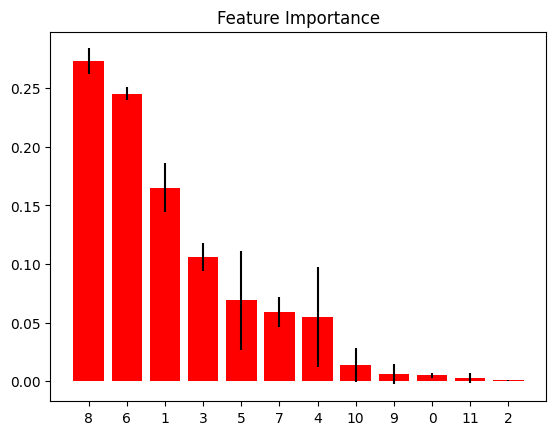

In [44]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis = 0)
indices = np.argsort(importances)[::-1]

# print feature ranking
data_aux_01 = pd.DataFrame()
for i, j in zip(x_train_n, forest.feature_importances_):
    aux_01 = pd.DataFrame({'Feature': i, 'Importance': j}, index = [0])
    data_aux_01 = pd.concat([data_aux_01, aux_01], axis = 0)

print(data_aux_01.sort_values('Importance', ascending = False))

plt.figure()
plt.title('Feature Importance')
plt.bar(range(x_train_n.shape[1]), importances[indices], color = 'r', yerr = std[indices], align = 'center')
plt.xticks(range(x_train_n.shape[1]), indices)
plt.xlim([-1, x_train_n.shape[1]])
plt.show()

# 7. MODELAGEM DOS DADOS

In [45]:
cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 'previously_insured', 'policy_sales_channel']

x_train = data_06_train[cols_selected]
x_val = data_06_validation[cols_selected]
y_val = data_05_validation.response.copy()

## 7.1. BALANCEAMENTO DOS DADOS

In [46]:
# balanceando os dados
over_sampler = SMOTE(k_neighbors = 2)
x_train_n, y_train_n = over_sampler.fit_resample(x_train, y_train)

## 7.2. APLICAÇÃO DE MODELOS

### 7.2.1.KNN

<Axes: title={'center': 'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

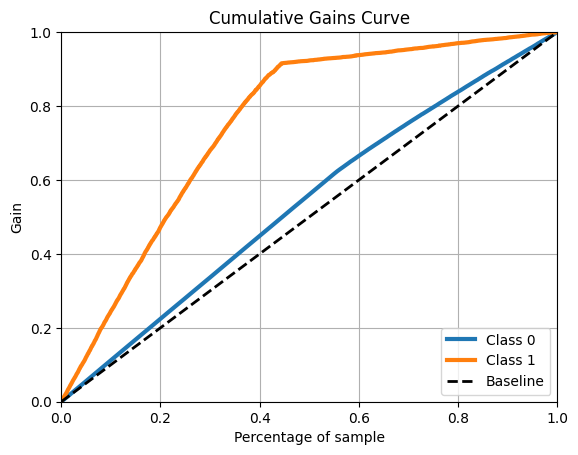

In [47]:
# definição do modelo
knn_model = KNeighborsClassifier(n_neighbors = 8)

# treinamento do modelo
knn_model.fit(x_train_n, y_train_n)

# predição do modelo - poder de generalização
y_hat_knn_model = knn_model.predict_proba(x_val)

# ganho cumulativo
skplt.metrics.plot_cumulative_gain(y_val, y_hat_knn_model)

### 7.2.2. LOGISTIC REGRESSION

<Axes: title={'center': 'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

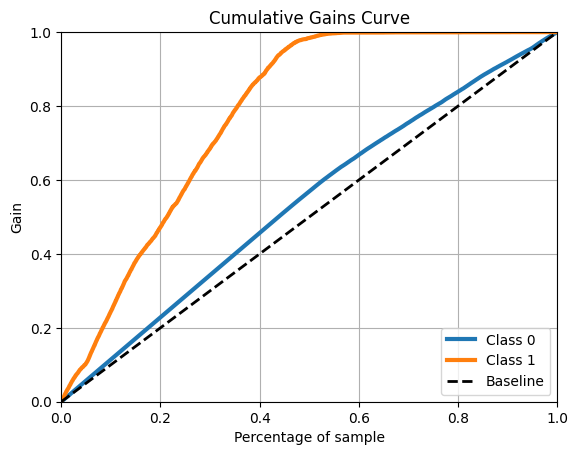

In [48]:
# definição do modelo
log_reg_model = LogisticRegression()

# treinamento do modelo
log_reg_model.fit(x_train_n, y_train_n)

# predição do modelo - poder de generalização
y_hat_log_reg_model = log_reg_model.predict_proba(x_val)

# ganho cumulativo
skplt.metrics.plot_cumulative_gain(y_val, y_hat_log_reg_model)

### 7.2.3. XBG CLASSIFIER

<Axes: title={'center': 'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

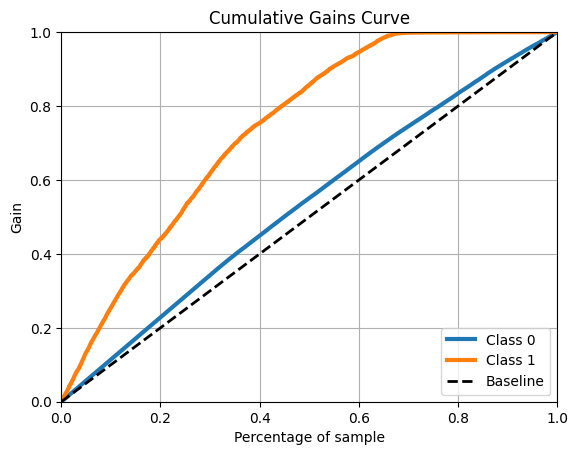

In [49]:
# definição do modelo
xgb_model = XGBClassifier()

# treinamento do modelo
xgb_model.fit(x_train_n, y_train_n)

# predição do modelo - poder de generalização
y_hat_xgb_model = xgb_model.predict_proba(x_val)

# ganho cumulativo
skplt.metrics.plot_cumulative_gain(y_val, y_hat_xgb_model)

### 7.2.4. EXTRA TREES

<Axes: title={'center': 'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

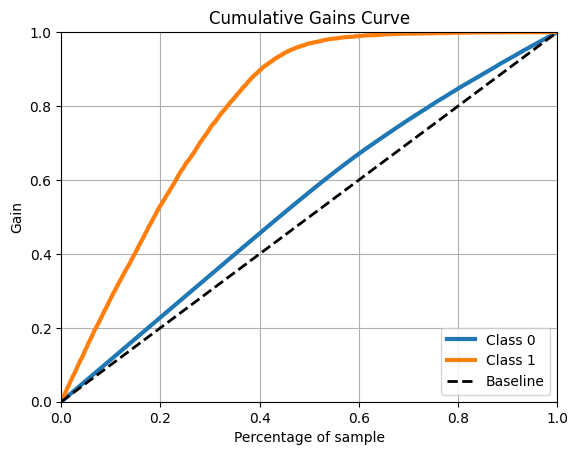

In [50]:
# definição do modelo
et_model = ExtraTreesClassifier(n_estimators = 100, n_jobs = -1, random_state = 42)

# treinamento do modelo
et_model.fit(x_train_n, y_train_n)

# predição do modelo - poder de generalização
y_hat_et_model = et_model.predict_proba(x_val)

# ganho cumulativo
skplt.metrics.plot_cumulative_gain(y_validation, y_hat_et_model)

# 8.0. PERFORMANCE DO MODELO

In [54]:
# copy data
data_08 = data_06_validation.copy()
data_08['response'] = y_validation.copy()

# propency score
data_08['score'] = y_hat_knn_model[:, 1].tolist()

# sort cliente by propensity score
data_08 = data_08.sort_values('score', ascending = False)

# verificando
precision_at_50 = precision_top_k(data_08, k = 100)
recall_at_50 = recall_top_k(data_08, k = 100)

print(f'Precision at k: {precision_at_50}')
print(f'Recall at k: {recall_at_50}')

Precision at k: 0.24752475247524752
Recall at k: 0.0026252231439672373
